# Ablation Study 2.5: Feature Transform Analysis

## Motivation

PointNet uses a feature transformation network (T-Net) to learn a 64-dimensional feature space transformation. The current implementation uses `feature_transform=True` in the PointNetEncoder. This ablation examines whether this feature transformation is necessary or if it can be removed to simplify the model while maintaining performance.

## Experimental Plan

1. Compare two configurations:
   - With feature transform: `feature_transform=True` (baseline)
   - Without feature transform: `feature_transform=False`
2. Keep all other hyperparameters constant (step=1, temp=5.0, spike=True)
3. Train models on ModelNet40 dataset
4. Compare accuracy, parameter count, and training efficiency

## Expected Insight

This experiment quantifies the benefit of the 64-dimensional feature transformation. If accuracy remains similar without it, the feature transform adds unnecessary complexity. If accuracy drops significantly, it validates the importance of learnable feature space transformations.

## Dataset Setup

Before running this notebook, ensure the ModelNet40 dataset is downloaded and extracted to: `data/modelnet40_normal_resampled/`

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import datetime
import importlib
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('..')
from data_utils.ModelNetDataLoader import ModelNetDataLoader
from models.spike_model import SpikeModel
from models.pointnet_utils import PointNetEncoder, feature_transform_reguliarzer
import provider

print('Imports successful!')
from cache_utils import load_training_history, save_training_history, cache_checkpoint, load_cached_checkpoint_path, best_metric
from viz_utils import plot_training_curves, summarize_histories, plot_metric_table, plot_metric_bars


Imports successful!


## Modified PointNet with Configurable Feature Transform

In [2]:
class PointNetWithConfigurableTransform(nn.Module):
    def __init__(self, k=40, normal_channel=True, use_feature_transform=True):
        super(PointNetWithConfigurableTransform, self).__init__()
        if normal_channel:
            channel = 6
        else:
            channel = 3
        
        self.use_feature_transform = use_feature_transform
        print(f'Using feature transform: {use_feature_transform}')
        
        self.feat = PointNetEncoder(global_feat=True, feature_transform=use_feature_transform, channel=channel)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)

        if len(x.shape) == 2:
            x = F.log_softmax(x, dim=1)
        else:
            x = F.log_softmax(x, dim=2)
        
        return x, trans_feat

class get_loss(torch.nn.Module):
    def __init__(self, mat_diff_loss_scale=0.001):
        super(get_loss, self).__init__()
        self.mat_diff_loss_scale = mat_diff_loss_scale

    def forward(self, pred, target, trans_feat):
        loss = F.nll_loss(pred, target)
        if trans_feat is not None:
            mat_diff_loss = feature_transform_reguliarzer(trans_feat)
            total_loss = loss + mat_diff_loss * self.mat_diff_loss_scale
        else:
            total_loss = loss
        return total_loss

print('Modified PointNet model with configurable feature transform created!')

Modified PointNet model with configurable feature transform created!


## Configuration

In [3]:
class Args:
    def __init__(self, use_feature_transform=True, num_category=40):
        self.use_cpu = False
        self.gpu = '0'
        self.batch_size = 24
        self.model = 'pointnet_cls'
        self.num_category = num_category
        self.epoch = 200
        self.learning_rate = 0.001
        self.num_point = 1024
        self.optimizer = 'Adam'
        transform_str = 'with_transform' if use_feature_transform else 'no_transform'
        self.log_dir = f'ablation_{transform_str}_modelnet{num_category}'
        self.decay_rate = 1e-4
        self.use_normals = False
        self.process_data = False
        self.use_uniform_sample = False
        self.step = 1
        self.spike = True
        self.temp = 5.0
        self.use_feature_transform = use_feature_transform

# Configuration with feature transform (baseline)
args_with_transform = Args(use_feature_transform=True, num_category=40)
print(f'With feature transform: {args_with_transform.log_dir}')

# Configuration without feature transform
args_no_transform = Args(use_feature_transform=False, num_category=40)
print(f'Without feature transform: {args_no_transform.log_dir}')

With feature transform: ablation_with_transform_modelnet40
Without feature transform: ablation_no_transform_modelnet40


## Helper Functions

In [4]:
def setup_experiment(args):
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    exp_dir = Path('../log/classification') / args.log_dir
    exp_dir.mkdir(parents=True, exist_ok=True)
    checkpoints_dir = exp_dir / 'checkpoints'
    checkpoints_dir.mkdir(exist_ok=True)
    return exp_dir, checkpoints_dir

def load_data(args):
    data_path = 'C:\\Users\\VIICTTE\\ML_Project\\modelnet40_normal_resampled'
    train_dataset = ModelNetDataLoader(root=data_path, args=args, split='train')
    test_dataset = ModelNetDataLoader(root=data_path, args=args, split='test')
    trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
    testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    return trainDataLoader, testDataLoader

def create_model(args):
    classifier = PointNetWithConfigurableTransform(k=args.num_category, normal_channel=args.use_normals, use_feature_transform=args.use_feature_transform)
    if args.spike:
        classifier = SpikeModel(classifier, args.step, args.temp)
        classifier.set_spike_state(True)
    criterion = get_loss()
    if not args.use_cpu:
        classifier = classifier.cuda()
        criterion = criterion.cuda()
    return classifier, criterion

print('Helper functions defined!')

Helper functions defined!


## Training Function

In [5]:
def train_model(args, exp_dir, checkpoints_dir, max_epochs=None):
    if max_epochs:
        args.epoch = max_epochs
    trainDataLoader, testDataLoader = load_data(args)
    classifier, criterion = create_model(args)
    
    total_params = sum(p.numel() for p in classifier.parameters())
    print(f'Total parameters: {total_params:,}')
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.decay_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
    
    best_acc = 0.0
    history = []
    
    transform_str = 'with' if args.use_feature_transform else 'without'
    print(f'Training {transform_str} feature transform')
    
    for epoch in range(args.epoch):
        print(f'Epoch {epoch+1}/{args.epoch}')
        classifier.train()
        scheduler.step()
        mean_correct = []
        
        for points, target in tqdm(trainDataLoader):
            optimizer.zero_grad()
            points = points.data.numpy()
            points = provider.random_point_dropout(points)
            points[:,:,0:3] = provider.random_scale_point_cloud(points[:,:,0:3])
            points[:,:,0:3] = provider.shift_point_cloud(points[:,:,0:3])
            points = torch.Tensor(points).transpose(2, 1)
            if not args.use_cpu:
                points, target = points.cuda(), target.cuda()
            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            loss.backward()
            optimizer.step()
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
        
        train_acc = np.mean(mean_correct)
        
        with torch.no_grad():
            classifier.eval()
            test_correct = []
            for points, target in testDataLoader:
                if not args.use_cpu:
                    points, target = points.cuda(), target.cuda()
                points = points.transpose(2, 1)
                pred, _ = classifier(points)
                pred_choice = pred.data.max(1)[1]
                correct = pred_choice.eq(target.long().data).cpu().sum()
                test_correct.append(correct.item() / float(points.size()[0]))
            test_acc = np.mean(test_correct)
        
        print(f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        history.append({'epoch': epoch+1, 'train_acc': train_acc, 'test_acc': test_acc})
        
        if test_acc >= best_acc:
            best_acc = test_acc
            torch.save({'model_state_dict': classifier.state_dict()}, str(checkpoints_dir / 'best_model.pth'))
    
    return classifier, history, best_acc, total_params

print('Training function defined!')

Training function defined!


## Train Models

**Note**: Training takes significant time. Consider reducing epochs for testing.

In [6]:
# Train with feature transform
print("=== Training WITH Feature Transform ===")
BASELINE_CACHE_NAME = 'baseline_step_1'
history_with, metadata_with = load_training_history(BASELINE_CACHE_NAME, with_metadata=True)
if history_with:
    best_acc_with = best_metric(history_with, ['test_acc', 'test_instance_acc']) or 0.0
    classifier_with, _ = create_model(args_with_transform)
    params_with = sum(p.numel() for p in classifier_with.parameters())
    classifier_with = None
    print(f"Loaded cached baseline history with {len(history_with)} epoch(s). Best accuracy: {best_acc_with:.4f}")
    cached_ckpt = load_cached_checkpoint_path(BASELINE_CACHE_NAME)
    if cached_ckpt:
        print(f'Cached baseline checkpoint available at: {cached_ckpt}')
else:
    print('No cached baseline history found; training feature-transform baseline from scratch.')
    exp_dir_with, ckpt_dir_with = setup_experiment(args_with_transform)
    classifier_with, history_with, best_acc_with, params_with = train_model(args_with_transform, exp_dir_with, ckpt_dir_with, max_epochs=200)
    metadata = {
        'variant': 'baseline_with_feature_transform',
        'config': dict(vars(args_with_transform)),
        'max_epochs': args_with_transform.epoch,
    }
    history_path = save_training_history(history_with, BASELINE_CACHE_NAME, metadata=metadata)
    print(f'Saved baseline history to {history_path}')
    best_ckpt = ckpt_dir_with / 'best_model.pth'
    if best_ckpt.exists():
        cached_ckpt = cache_checkpoint(best_ckpt, BASELINE_CACHE_NAME)
        print(f'Cached baseline checkpoint to {cached_ckpt}')
print(f'With Transform: Best Accuracy = {best_acc_with:.4f}, Parameters = {params_with:,}')

=== Training WITH Feature Transform ===
Using feature transform: True
Loaded cached baseline history with 200 epoch(s). Best accuracy: 0.8818
Cached baseline checkpoint available at: ..\artifacts\spikepointnet\checkpoints\baseline_step_1.pth
With Transform: Best Accuracy = 0.8818, Parameters = 3,483,377


In [7]:
# Train without feature transform
print('\n=== Training WITHOUT Feature Transform ===')
exp_dir_no, ckpt_dir_no = setup_experiment(args_no_transform)
classifier_no, history_no, best_acc_no, params_no = train_model(args_no_transform, exp_dir_no, ckpt_dir_no, max_epochs=200)
print(f'Without Transform: Best Accuracy = {best_acc_no:.4f}, Parameters = {params_no:,}')


=== Training WITHOUT Feature Transform ===
The size of train data is 9843
The size of test data is 2468
Using feature transform: False
Total parameters: 1,622,065
Training without feature transform
Epoch 1/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:26<00:00, 15.64it/s]


Train Acc: 0.4394, Test Acc: 0.0688
Epoch 2/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:16<00:00, 24.56it/s]


Train Acc: 0.5760, Test Acc: 0.0526
Epoch 3/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:16<00:00, 25.11it/s]


Train Acc: 0.6254, Test Acc: 0.3078
Epoch 4/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:16<00:00, 24.89it/s]


Train Acc: 0.6510, Test Acc: 0.3244
Epoch 5/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:16<00:00, 25.16it/s]


Train Acc: 0.6821, Test Acc: 0.2679
Epoch 6/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:16<00:00, 25.60it/s]


Train Acc: 0.6937, Test Acc: 0.4494
Epoch 7/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.7027, Test Acc: 0.5444
Epoch 8/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.18it/s]


Train Acc: 0.7139, Test Acc: 0.5748
Epoch 9/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.15it/s]


Train Acc: 0.7306, Test Acc: 0.6017
Epoch 10/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.23it/s]


Train Acc: 0.7304, Test Acc: 0.5883
Epoch 11/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.18it/s]


Train Acc: 0.7330, Test Acc: 0.6176
Epoch 12/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.7411, Test Acc: 0.6385
Epoch 13/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.7527, Test Acc: 0.7016
Epoch 14/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.7488, Test Acc: 0.7259
Epoch 15/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.7515, Test Acc: 0.6763
Epoch 16/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.12it/s]


Train Acc: 0.7532, Test Acc: 0.7546
Epoch 17/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.7612, Test Acc: 0.7859
Epoch 18/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.24it/s]


Train Acc: 0.7699, Test Acc: 0.7870
Epoch 19/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.21it/s]


Train Acc: 0.7663, Test Acc: 0.7880
Epoch 20/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.19it/s]


Train Acc: 0.7809, Test Acc: 0.8173
Epoch 21/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.7940, Test Acc: 0.8048
Epoch 22/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.24it/s]


Train Acc: 0.7929, Test Acc: 0.5581
Epoch 23/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.7926, Test Acc: 0.6886
Epoch 24/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.7979, Test Acc: 0.8127
Epoch 25/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.7973, Test Acc: 0.6396
Epoch 26/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8025, Test Acc: 0.7940
Epoch 27/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.7996, Test Acc: 0.7191
Epoch 28/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.18it/s]


Train Acc: 0.8024, Test Acc: 0.8133
Epoch 29/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8069, Test Acc: 0.8013
Epoch 30/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8099, Test Acc: 0.8265
Epoch 31/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8065, Test Acc: 0.8218
Epoch 32/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8069, Test Acc: 0.8356
Epoch 33/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8078, Test Acc: 0.8180
Epoch 34/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8085, Test Acc: 0.8177
Epoch 35/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8098, Test Acc: 0.8323
Epoch 36/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8141, Test Acc: 0.8286
Epoch 37/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8126, Test Acc: 0.8105
Epoch 38/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8164, Test Acc: 0.8243
Epoch 39/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.23it/s]


Train Acc: 0.8143, Test Acc: 0.8393
Epoch 40/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.02it/s]


Train Acc: 0.8324, Test Acc: 0.8368
Epoch 41/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8277, Test Acc: 0.8382
Epoch 42/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8276, Test Acc: 0.8442
Epoch 43/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8343, Test Acc: 0.8463
Epoch 44/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.36it/s]


Train Acc: 0.8313, Test Acc: 0.8512
Epoch 45/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8320, Test Acc: 0.8400
Epoch 46/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.8285, Test Acc: 0.8400
Epoch 47/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8327, Test Acc: 0.8477
Epoch 48/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8335, Test Acc: 0.8456
Epoch 49/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8339, Test Acc: 0.8531
Epoch 50/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8239, Test Acc: 0.8436
Epoch 51/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8322, Test Acc: 0.8447
Epoch 52/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.39it/s]


Train Acc: 0.8310, Test Acc: 0.8455
Epoch 53/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8355, Test Acc: 0.8450
Epoch 54/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8355, Test Acc: 0.8396
Epoch 55/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8348, Test Acc: 0.8415
Epoch 56/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.21it/s]


Train Acc: 0.8325, Test Acc: 0.8382
Epoch 57/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8364, Test Acc: 0.8546
Epoch 58/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8303, Test Acc: 0.8485
Epoch 59/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.36it/s]


Train Acc: 0.8397, Test Acc: 0.8544
Epoch 60/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8461, Test Acc: 0.8521
Epoch 61/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8500, Test Acc: 0.8450
Epoch 62/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8433, Test Acc: 0.8487
Epoch 63/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8475, Test Acc: 0.8570
Epoch 64/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8468, Test Acc: 0.8426
Epoch 65/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8515, Test Acc: 0.8557
Epoch 66/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8493, Test Acc: 0.8537
Epoch 67/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8511, Test Acc: 0.8445
Epoch 68/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.41it/s]


Train Acc: 0.8551, Test Acc: 0.8529
Epoch 69/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8519, Test Acc: 0.8628
Epoch 70/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8503, Test Acc: 0.8452
Epoch 71/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8431, Test Acc: 0.8603
Epoch 72/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8505, Test Acc: 0.8558
Epoch 73/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.8530, Test Acc: 0.8587
Epoch 74/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.40it/s]


Train Acc: 0.8561, Test Acc: 0.8590
Epoch 75/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8550, Test Acc: 0.8645
Epoch 76/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8563, Test Acc: 0.8629
Epoch 77/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8566, Test Acc: 0.8456
Epoch 78/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8568, Test Acc: 0.8600
Epoch 79/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8553, Test Acc: 0.8545
Epoch 80/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8628, Test Acc: 0.8688
Epoch 81/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8622, Test Acc: 0.8668
Epoch 82/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.41it/s]


Train Acc: 0.8603, Test Acc: 0.8703
Epoch 83/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8605, Test Acc: 0.8639
Epoch 84/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8618, Test Acc: 0.8676
Epoch 85/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8669, Test Acc: 0.8578
Epoch 86/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8631, Test Acc: 0.8561
Epoch 87/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8604, Test Acc: 0.8610
Epoch 88/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.36it/s]


Train Acc: 0.8633, Test Acc: 0.8617
Epoch 89/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8648, Test Acc: 0.8193
Epoch 90/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.41it/s]


Train Acc: 0.8668, Test Acc: 0.8635
Epoch 91/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.39it/s]


Train Acc: 0.8617, Test Acc: 0.8566
Epoch 92/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.42it/s]


Train Acc: 0.8631, Test Acc: 0.8700
Epoch 93/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.39it/s]


Train Acc: 0.8659, Test Acc: 0.8675
Epoch 94/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8679, Test Acc: 0.8646
Epoch 95/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8668, Test Acc: 0.8639
Epoch 96/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8700, Test Acc: 0.8627
Epoch 97/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.44it/s]


Train Acc: 0.8678, Test Acc: 0.8667
Epoch 98/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8673, Test Acc: 0.8628
Epoch 99/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.39it/s]


Train Acc: 0.8641, Test Acc: 0.8605
Epoch 100/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.41it/s]


Train Acc: 0.8749, Test Acc: 0.8602
Epoch 101/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8714, Test Acc: 0.8626
Epoch 102/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8754, Test Acc: 0.8707
Epoch 103/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8737, Test Acc: 0.8675
Epoch 104/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.39it/s]


Train Acc: 0.8750, Test Acc: 0.8622
Epoch 105/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.36it/s]


Train Acc: 0.8714, Test Acc: 0.8647
Epoch 106/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8739, Test Acc: 0.8679
Epoch 107/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8703, Test Acc: 0.8684
Epoch 108/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.24it/s]


Train Acc: 0.8792, Test Acc: 0.8768
Epoch 109/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.38it/s]


Train Acc: 0.8708, Test Acc: 0.8719
Epoch 110/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8742, Test Acc: 0.8707
Epoch 111/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.36it/s]


Train Acc: 0.8696, Test Acc: 0.8709
Epoch 112/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8747, Test Acc: 0.8630
Epoch 113/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8725, Test Acc: 0.8667
Epoch 114/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8754, Test Acc: 0.8678
Epoch 115/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8740, Test Acc: 0.8648
Epoch 116/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.8714, Test Acc: 0.7439
Epoch 117/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8729, Test Acc: 0.8619
Epoch 118/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8746, Test Acc: 0.8720
Epoch 119/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8758, Test Acc: 0.8710
Epoch 120/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.22it/s]


Train Acc: 0.8786, Test Acc: 0.8755
Epoch 121/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.8801, Test Acc: 0.8690
Epoch 122/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8787, Test Acc: 0.8753
Epoch 123/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8793, Test Acc: 0.8756
Epoch 124/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8784, Test Acc: 0.8670
Epoch 125/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8798, Test Acc: 0.8712
Epoch 126/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.17it/s]


Train Acc: 0.8750, Test Acc: 0.8769
Epoch 127/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8808, Test Acc: 0.8768
Epoch 128/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8794, Test Acc: 0.8750
Epoch 129/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8791, Test Acc: 0.8595
Epoch 130/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8807, Test Acc: 0.8704
Epoch 131/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8793, Test Acc: 0.8680
Epoch 132/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8820, Test Acc: 0.8676
Epoch 133/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8783, Test Acc: 0.8650
Epoch 134/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8788, Test Acc: 0.8711
Epoch 135/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8851, Test Acc: 0.8713
Epoch 136/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8795, Test Acc: 0.8704
Epoch 137/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8859, Test Acc: 0.8736
Epoch 138/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8799, Test Acc: 0.8729
Epoch 139/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.22it/s]


Train Acc: 0.8849, Test Acc: 0.8694
Epoch 140/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.22it/s]


Train Acc: 0.8800, Test Acc: 0.8733
Epoch 141/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8876, Test Acc: 0.8701
Epoch 142/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8845, Test Acc: 0.8710
Epoch 143/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.04it/s]


Train Acc: 0.8873, Test Acc: 0.8688
Epoch 144/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8858, Test Acc: 0.8765
Epoch 145/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8827, Test Acc: 0.8704
Epoch 146/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8823, Test Acc: 0.8705
Epoch 147/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8832, Test Acc: 0.8701
Epoch 148/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8871, Test Acc: 0.8675
Epoch 149/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8878, Test Acc: 0.8686
Epoch 150/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8854, Test Acc: 0.8806
Epoch 151/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8887, Test Acc: 0.8830
Epoch 152/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8845, Test Acc: 0.8727
Epoch 153/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8912, Test Acc: 0.8704
Epoch 154/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8884, Test Acc: 0.8821
Epoch 155/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8873, Test Acc: 0.8696
Epoch 156/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8891, Test Acc: 0.8712
Epoch 157/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8908, Test Acc: 0.8721
Epoch 158/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8887, Test Acc: 0.8805
Epoch 159/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.26it/s]


Train Acc: 0.8887, Test Acc: 0.8733
Epoch 160/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.40it/s]


Train Acc: 0.8865, Test Acc: 0.8726
Epoch 161/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8910, Test Acc: 0.8776
Epoch 162/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8841, Test Acc: 0.8786
Epoch 163/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8878, Test Acc: 0.8765
Epoch 164/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8949, Test Acc: 0.8790
Epoch 165/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8893, Test Acc: 0.8786
Epoch 166/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8841, Test Acc: 0.8727
Epoch 167/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.22it/s]


Train Acc: 0.8897, Test Acc: 0.8691
Epoch 168/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.36it/s]


Train Acc: 0.8910, Test Acc: 0.8805
Epoch 169/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8922, Test Acc: 0.8756
Epoch 170/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8835, Test Acc: 0.8772
Epoch 171/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8910, Test Acc: 0.8813
Epoch 172/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8926, Test Acc: 0.8803
Epoch 173/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8922, Test Acc: 0.8756
Epoch 174/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8883, Test Acc: 0.8728
Epoch 175/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.40it/s]


Train Acc: 0.8927, Test Acc: 0.8748
Epoch 176/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.24it/s]


Train Acc: 0.8917, Test Acc: 0.8833
Epoch 177/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.41it/s]


Train Acc: 0.8875, Test Acc: 0.8715
Epoch 178/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8952, Test Acc: 0.8680
Epoch 179/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8903, Test Acc: 0.8813
Epoch 180/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8936, Test Acc: 0.8728
Epoch 181/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.30it/s]


Train Acc: 0.8935, Test Acc: 0.8724
Epoch 182/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.14it/s]


Train Acc: 0.8945, Test Acc: 0.8749
Epoch 183/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.27it/s]


Train Acc: 0.8952, Test Acc: 0.8769
Epoch 184/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.34it/s]


Train Acc: 0.8939, Test Acc: 0.8736
Epoch 185/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8891, Test Acc: 0.8719
Epoch 186/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8921, Test Acc: 0.8777
Epoch 187/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8919, Test Acc: 0.8736
Epoch 188/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8917, Test Acc: 0.8777
Epoch 189/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.29it/s]


Train Acc: 0.8964, Test Acc: 0.8745
Epoch 190/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.17it/s]


Train Acc: 0.8952, Test Acc: 0.8794
Epoch 191/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.28it/s]


Train Acc: 0.8922, Test Acc: 0.8786
Epoch 192/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.35it/s]


Train Acc: 0.8917, Test Acc: 0.8710
Epoch 193/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8977, Test Acc: 0.8763
Epoch 194/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.37it/s]


Train Acc: 0.8914, Test Acc: 0.8760
Epoch 195/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8945, Test Acc: 0.8731
Epoch 196/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.25it/s]


Train Acc: 0.8938, Test Acc: 0.8774
Epoch 197/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.33it/s]


Train Acc: 0.8896, Test Acc: 0.8733
Epoch 198/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.31it/s]


Train Acc: 0.8958, Test Acc: 0.8761
Epoch 199/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.32it/s]


Train Acc: 0.8927, Test Acc: 0.8706
Epoch 200/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:13<00:00, 30.24it/s]


Train Acc: 0.8936, Test Acc: 0.8719
Without Transform: Best Accuracy = 0.8833, Parameters = 1,622,065


## Visualization and Analysis

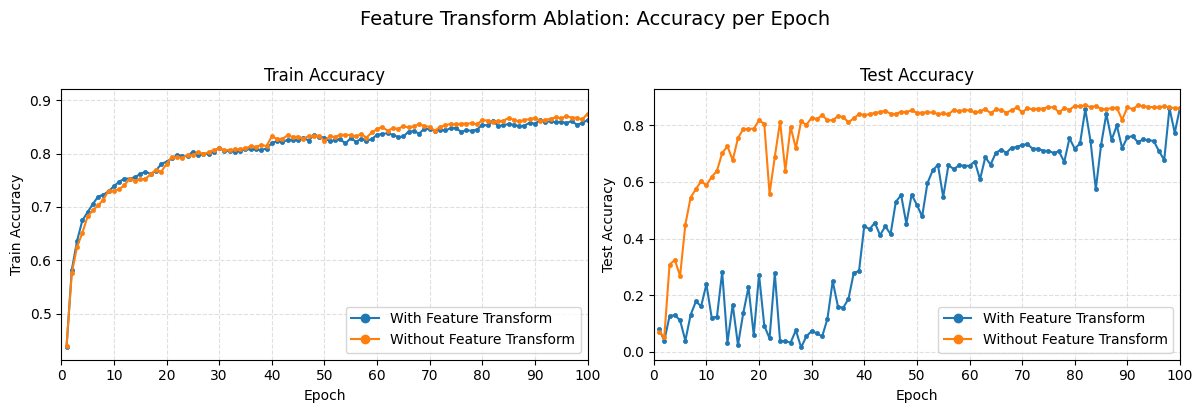

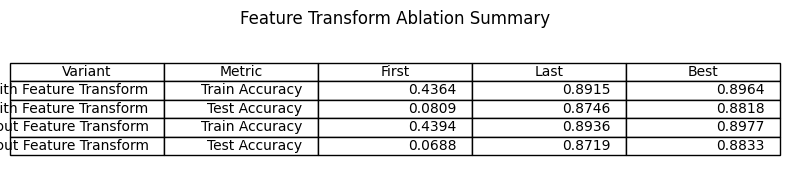

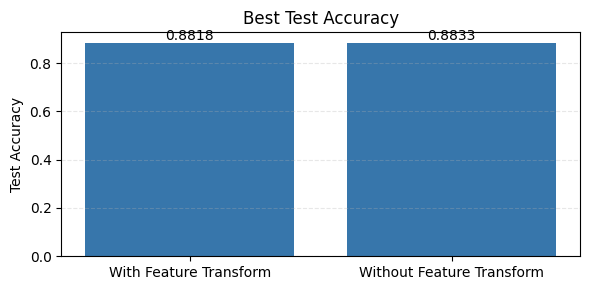

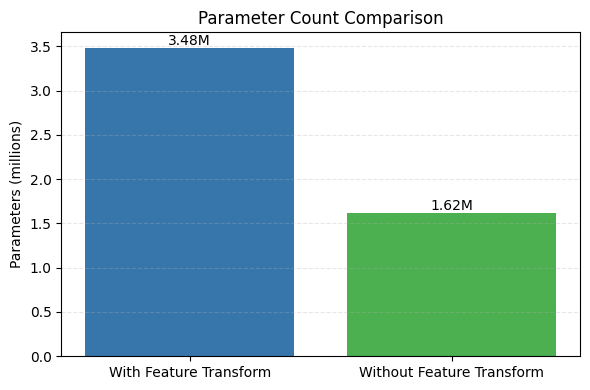

Detailed metrics:
  With Feature Transform: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Without Feature Transform: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
Parameter counts:
  With Feature Transform: 3,483,377 parameters
  Without Feature Transform: 1,622,065 parameters


In [8]:
import matplotlib.pyplot as plt
from pathlib import Path

metrics = {
    "Train Accuracy": ["train_acc"],
    "Test Accuracy": ["test_instance_acc", "test_acc"],
}

available_histories = {}
if 'history_with' in locals() and history_with:
    available_histories['With Feature Transform'] = history_with
if 'history_no' in locals() and history_no:
    available_histories['Without Feature Transform'] = history_no

if not available_histories:
    print('No training history available for visualization. Run the training cells above first.')
else:
    fig, axes = plot_training_curves(
        available_histories,
        metrics,
        title="Feature Transform Ablation: Accuracy per Epoch"
    )
    for ax in np.ravel(axes):
            # Reduce scatter marker size
            for line in ax.lines:
                line.set_marker("o")
                line.set_markersize(3)  # smaller dots
                line.set_markeredgewidth(0.5)
            # Limit range
            ax.set_xlim(0, 100)
            ax.grid(True, linestyle="--", alpha=0.4)
    figures_dir = Path("../log/figures") / "feature_transform"
    figures_dir.mkdir(parents=True, exist_ok=True)
    curve_path = figures_dir / "accuracy_curves.png"
    fig.savefig(curve_path, dpi=150, bbox_inches="tight")
    plt.show()

    summary_stats = summarize_histories(available_histories, metrics)
    table_fig, table_ax = plot_metric_table(
        summary_stats,
        title="Feature Transform Ablation Summary",
        value_fmt="{:.4f}",
        include_first=True
    )
    table_path = figures_dir / "accuracy_summary.png"
    table_fig.savefig(table_path, dpi=150, bbox_inches="tight")
    plt.show()

    bar_fig, bar_ax = plot_metric_bars(
        summary_stats,
        metric_name="Test Accuracy",
        title="Best Test Accuracy",
        ylabel="Test Accuracy"
    )
    bar_path = figures_dir / "best_accuracy.png"
    bar_fig.savefig(bar_path, dpi=150, bbox_inches="tight")
    plt.show()

    if 'params_with' in locals() and 'params_no' in locals():
        param_fig, param_ax = plt.subplots(figsize=(6, 4))
        labels = ['With Feature Transform', 'Without Feature Transform']
        values = [params_with / 1e6, params_no / 1e6]
        bars = param_ax.bar(labels, values, color=['#3776ab', '#4caf50'])
        param_ax.set_ylabel('Parameters (millions)')
        param_ax.set_title('Parameter Count Comparison')
        param_ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        for bar, value in zip(bars, values):
            param_ax.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}M', ha='center', va='bottom')
        param_fig.tight_layout()
        param_path = figures_dir / "parameter_comparison.png"
        param_fig.savefig(param_path, dpi=150, bbox_inches="tight")
        plt.show()

    def _fmt(value):
        return '-' if value is None else f"{value:.4f}"

    print('Detailed metrics:')
    for label, metric_stats in summary_stats.items():
        stats = metric_stats.get("Test Accuracy", {})
        print(f"  {label}: first={{_fmt(stats.get('first'))}}, last={{_fmt(stats.get('last'))}}, best={{_fmt(stats.get('best'))}}")

    if 'params_with' in locals() and 'params_no' in locals():
        print('Parameter counts:')
        print(f"  With Feature Transform: {params_with:,} parameters")
        print(f"  Without Feature Transform: {params_no:,} parameters")


## Summary and Insights

In [9]:
print('\n' + '='*60)
print('ABLATION STUDY 2.5 SUMMARY: FEATURE TRANSFORM')
print('='*60)

print('\n1. Final Accuracy Results:')
print(f'   With Feature Transform:    {best_acc_with:.4f}')
print(f'   Without Feature Transform: {best_acc_no:.4f}')
print(f'   Difference: {(best_acc_with - best_acc_no)*100:.2f}%')

print('\n2. Model Complexity:')
print(f'   With Feature Transform:    {params_with:,} parameters')
print(f'   Without Feature Transform: {params_no:,} parameters')
print(f'   Reduction: {params_with - params_no:,} parameters ({(params_with - params_no)/params_with*100:.1f}%)')

print('\n3. Key Insights:')
if best_acc_with > best_acc_no + 0.01:
    print('   - Feature transform SIGNIFICANTLY improves accuracy')
    print('   - The 64-dimensional feature space transformation is beneficial')
    print('   - Additional complexity is justified by performance gain')
    print('   - Learnable transformations help adapt to data distribution')
elif best_acc_with > best_acc_no:
    print('   - Feature transform slightly improves accuracy')
    print('   - Marginal benefit from feature space transformation')
    print('   - Trade-off between complexity and performance')
else:
    print('   - Feature transform does NOT improve accuracy')
    print('   - The additional complexity is not justified')
    print('   - Identity mapping or simpler transformations may suffice')
    print('   - Model can be simplified without sacrificing performance')

print('\n4. Efficiency Analysis:')
print(f'   - Parameter overhead: {(params_with - params_no)/1e6:.2f}M parameters')
print(f'   - Accuracy gain: {(best_acc_with - best_acc_no)*100:.2f}%')
if params_with > params_no:
    efficiency = ((best_acc_with - best_acc_no)*100) / ((params_with - params_no)/1e6)
    print(f'   - Efficiency: {efficiency:.3f}% accuracy per million parameters')

print('\n5. Recommendations:')
if best_acc_with > best_acc_no + 0.01:
    print('   - Keep feature transform for applications where accuracy is critical')
    print('   - The performance gain justifies the added complexity')
else:
    print('   - Consider removing feature transform for efficiency')
    print('   - Simpler model with similar performance')
    print('   - Better for deployment on resource-constrained devices')

print('\n' + '='*60)


ABLATION STUDY 2.5 SUMMARY: FEATURE TRANSFORM

1. Final Accuracy Results:
   With Feature Transform:    0.8818
   Without Feature Transform: 0.8833
   Difference: -0.15%

2. Model Complexity:
   With Feature Transform:    3,483,377 parameters
   Without Feature Transform: 1,622,065 parameters
   Reduction: 1,861,312 parameters (53.4%)

3. Key Insights:
   - Feature transform does NOT improve accuracy
   - The additional complexity is not justified
   - Identity mapping or simpler transformations may suffice
   - Model can be simplified without sacrificing performance

4. Efficiency Analysis:
   - Parameter overhead: 1.86M parameters
   - Accuracy gain: -0.15%
   - Efficiency: -0.083% accuracy per million parameters

5. Recommendations:
   - Consider removing feature transform for efficiency
   - Simpler model with similar performance
   - Better for deployment on resource-constrained devices

